Install Contrastive

In [1]:
!pip install contrastive

  Preparing metadata (setup.py) ... done
  Created wheel for contrastive: filename=contrastive-1.2.0-py3-none-any.whl size=6898 sha256=9d397164ac5dbca84ca765dbde4f618eb32785bd52a55e4942f20104cf9f745a
  Stored in directory: /root/.cache/pip/wheels/b4/2a/ad/111239c0d6a0b248f0ee4b903b6b44cc9cdfc1cfcff81ebba2
Successfully built contrastive


Download Wine dataset

In [1]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

import numpy as np

data = load_wine()
print(data.keys())


X_data = np.asarray(data["data"])
y_data = np.asarray(data["target"])

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names'])


In [2]:
print(X_data.shape)
print(y_data.shape)

(178, 13)
(178,)


Create a noise generator feature

In [3]:
N_DIM = X_data.shape[1]
N_ROWS = X_data.shape[0]
X_data_noise = np.zeros((N_DIM, N_ROWS))
for feature in range(N_DIM):
    original_mean = np.mean(X_data[:,feature])
    original_std = np.std(X_data[:,feature])
    X_data_noise[feature] = np.random.normal(original_mean, original_std, N_ROWS)

Visualize real data and data with noise generation

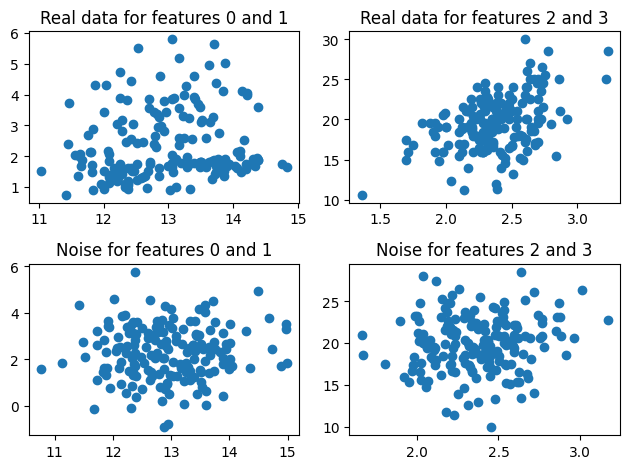

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2)
axs[0, 0].set_title("Real data for features 0 and 1")
axs[0, 0].scatter(X_data[:,0], X_data[:,1])
axs[0, 1].set_title("Real data for features 2 and 3")
axs[0, 1].scatter(X_data[:,2], X_data[:,3])
axs[1, 0].set_title("Noise for features 0 and 1")
axs[1, 0].scatter(X_data_noise[0], X_data_noise[1])
axs[1, 1].set_title("Noise for features 2 and 3")
axs[1, 1].scatter(X_data_noise[2], X_data_noise[3])
fig.tight_layout()

Implement PCA on 2 dimensions

In [5]:
from sklearn.decomposition import PCA

pca_model = PCA(n_components=2)
X_data_original_compress = pca_model.fit_transform(X_data)

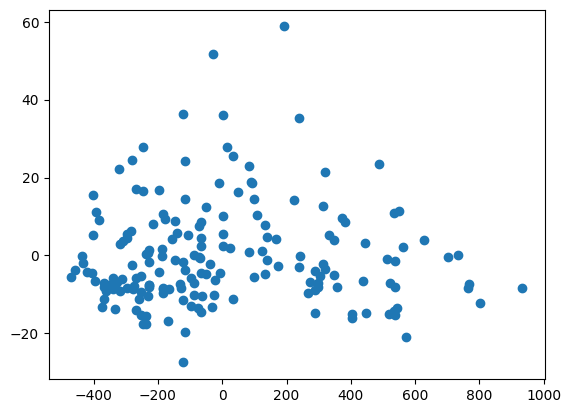

In [6]:
plt.scatter(X_data_original_compress[:,0], X_data_original_compress[:,1])

Run PCA

In [7]:
from contrastive import CPCA

print(X_data.shape)
print(X_data_noise.T.shape)
cpca_model = CPCA(n_components=2)
transformed_data = cpca_model.fit_transform(X_data, X_data_noise.T)
transformed_data = np.asarray(transformed_data)
print(transformed_data.shape)

(178, 13)
(178, 13)
(4, 178, 2)


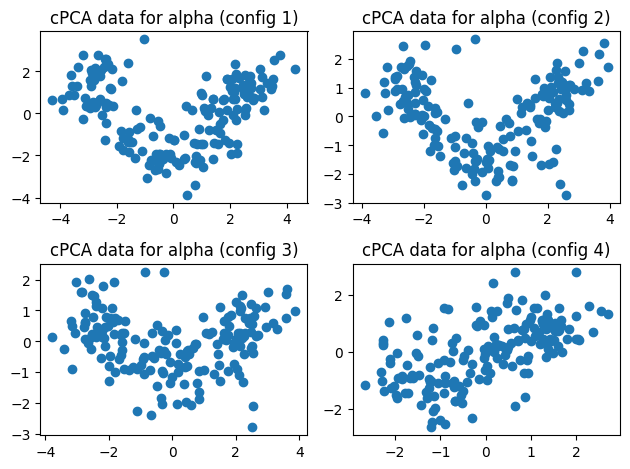

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2)
P = transformed_data
axs[0, 0].set_title("cPCA data for alpha (config 1)")
axs[0, 0].scatter(P[0,:,0], P[0,:,1])
axs[0, 1].set_title("cPCA data for alpha (config 2)")
axs[0, 1].scatter(P[1,:,0], P[1,:,1])
axs[1, 0].set_title("cPCA data for alpha (config 3)")
axs[1, 0].scatter(P[2,:,0], P[2,:,1])
axs[1, 1].set_title("cPCA data for alpha (config 4)")
axs[1, 1].scatter(P[3,:,0], P[3,:,1])
fig.tight_layout()

Running k-NN on PCA-compressed data

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

mean_acc = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_data_original_compress, y_data)
    knn_clf = KNeighborsClassifier(n_neighbors=5)
    knn_clf.fit(X_train, y_train)
    mean_acc.append(knn_clf.score(X_test, y_test))
print(f"{round(np.mean(mean_acc),5)} +/- {round(np.std(mean_acc),5)}")

0.72 +/- 0.05639


Running k-NN on original dataset

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

mean_acc = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data)
    knn_clf = KNeighborsClassifier(n_neighbors=5)
    knn_clf.fit(X_train, y_train)
    mean_acc.append(knn_clf.score(X_test, y_test))
print(f"{round(np.mean(mean_acc),5)} +/- {round(np.std(mean_acc),5)}")

0.69778 +/- 0.0424


Running on cPCA-compressed data, with different values for alpha (cPCA parameter)

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

for i in range(len(transformed_data)):
    mean_acc = []
    for j in range(10):
        X_train, X_test, y_train, y_test = train_test_split(transformed_data[i], y_data)
        knn_clf = KNeighborsClassifier(n_neighbors=5)
        knn_clf.fit(X_train, y_train)
        mean_acc.append(knn_clf.score(X_test, y_test))
    print(f"{round(np.mean(mean_acc),5)} +/- {round(np.std(mean_acc),5)}")

0.96667 +/- 0.02049
0.91111 +/- 0.03849
0.87333 +/- 0.06049
0.77111 +/- 0.05967


### Running 5-Fold Validation by using the Third Class as Background

In [12]:
print(X_data.shape)
print(y_data.shape)
list_of_unique_labels = np.unique(y_data)
print(list_of_unique_labels)

(178, 13)
(178,)
[0 1 2]


In [13]:
from sklearn.decomposition import PCA
from contrastive import CPCA
import sklearn as sk
from sklearn.neighbors import KNeighborsClassifier

In [14]:
from sklearn.model_selection import cross_val_score

results_list = []

for i in range(len(list_of_unique_labels)):
    for j in range(len(list_of_unique_labels)):
        if i>j:
            tmp_data_dict = dict()
            tmp_data_dict["name"] = f"Class {i} and Class {j}"
            class_1_indices = np.where(y_data==i)[0]
            # print(class_1_indices)
            class_2_indices = np.where(y_data==j)[0]
            class_1_data = np.take(X_data, class_1_indices, axis=0)
            # print(class_1_data)
            class_2_data = np.take(X_data, class_2_indices,axis=0)
            # print(class_1_data.shape)
            # print(class_2_data.shape)
            background_indices = []
            # y_data_indices = np.zeros(class_1_data.shape[0]+class_2_data.shape[0])
            for k in range(X_data.shape[0]):
                if k not in class_1_indices and k not in class_2_indices:
                    background_indices.append(k)
            background_data = np.take(X_data, background_indices,axis=0)

            X_data_p = np.concatenate((class_1_data, class_2_data), axis=0)
            X_data_noise = background_data
            y_data_p = np.zeros(class_1_data.shape[0]+class_2_data.shape[0])
            class_1_indices = list(range(class_1_data.shape[0]))
            y_data_p[class_1_indices]=1
            X_data_p, y_data_p = sk.utils.shuffle(X_data_p, y_data_p)

            
            print(X_data_p.shape)
            print(X_data_noise.shape)
            
            # PCA processing
            pca_model = PCA(n_components=2)
            X_data_original_compress = pca_model.fit_transform(X_data_p)
            
            # cPCA preprocessing
            cpca_model = CPCA(n_components=2)
            transformed_data = cpca_model.fit_transform(X_data_p, X_data_noise)
            transformed_data = np.asarray(transformed_data)
            # print(transformed_data.shape)

            # PCA data
            clf = KNeighborsClassifier(n_neighbors=5)
            scores = cross_val_score(clf, X_data_original_compress, y_data_p, cv=5)
            print("PCA")
            print(f"Mean: {round(scores.mean(),3)}")
            print(f"Std: {round(scores.std(),3)}")
            print()
            tmp_data_dict["PCA"] = f"{round(scores.mean(),3)} +/- {round(scores.std(),3)}"
            
            # cPCA data
            clf = KNeighborsClassifier(n_neighbors=5)
            scores = cross_val_score(clf, transformed_data[0], y_data_p, cv=5)
            # pprint(scores)
            print("cPCA (custom alpha 1)")
            print(f"Mean: {round(scores.mean(),3)}")
            print(f"Std: {round(scores.std(),3)}")
            print()
            tmp_data_dict["cPCA-1"] = f"{round(scores.mean(),3)} +/- {round(scores.std(),3)}"

            # cPCA data
            clf = KNeighborsClassifier(n_neighbors=5)
            scores = cross_val_score(clf, transformed_data[1], y_data_p, cv=5)
            # pprint(scores)
            print("cPCA (custom alpha 2)")
            print(f"Mean: {round(scores.mean(),3)}")
            print(f"Std: {round(scores.std(),3)}")
            print()
            tmp_data_dict["cPCA-2"] = f"{round(scores.mean(),3)} +/- {round(scores.std(),3)}"

            # cPCA data
            clf = KNeighborsClassifier(n_neighbors=5)
            scores = cross_val_score(clf, transformed_data[2], y_data_p, cv=5)
            # pprint(scores)
            print("cPCA (custom alpha 3)")
            print(f"Mean: {round(scores.mean(),3)}")
            print(f"Std: {round(scores.std(),3)}")
            print()
            tmp_data_dict["cPCA-3"] = f"{round(scores.mean(),3)} +/- {round(scores.std(),3)}"

            # cPCA data
            clf = KNeighborsClassifier(n_neighbors=5)
            scores = cross_val_score(clf, transformed_data[3], y_data_p, cv=5)
            # pprint(scores)
            print("cPCA (custom alpha 4)")
            print(f"Mean: {round(scores.mean(),3)}")
            print(f"Std: {round(scores.std(),3)}")
            print()
            tmp_data_dict["cPCA-4"] = f"{round(scores.mean(),3)} +/- {round(scores.std(),3)}"

            # on original data
            clf = KNeighborsClassifier(n_neighbors=5)
            scores = cross_val_score(clf, X_data_p, y_data_p, cv=5)
            # pprint(scores)
            print("Original data")
            print(f"Mean: {round(scores.mean(),3)}")
            print(f"Std: {round(scores.std(),3)}")
            print()
            print("---")
            tmp_data_dict["original"] = f"{round(scores.mean(),3)} +/- {round(scores.std(),3)}"
            results_list.append(tmp_data_dict)

(130, 13)
(48, 13)
PCA
Mean: 0.954
Std: 0.038

cPCA (custom alpha 1)
Mean: 0.908
Std: 0.019

cPCA (custom alpha 2)
Mean: 0.962
Std: 0.024

cPCA (custom alpha 3)
Mean: 0.885
Std: 0.042

cPCA (custom alpha 4)
Mean: 0.669
Std: 0.046

Original data
Mean: 0.954
Std: 0.038

---
(107, 13)
(71, 13)
PCA
Mean: 0.889
Std: 0.11

cPCA (custom alpha 1)
Mean: 1.0
Std: 0.0

cPCA (custom alpha 2)
Mean: 1.0
Std: 0.0

cPCA (custom alpha 3)
Mean: 1.0
Std: 0.0

cPCA (custom alpha 4)
Mean: 0.953
Std: 0.043

Original data
Mean: 0.889
Std: 0.11

---
(119, 13)
(59, 13)
PCA
Mean: 0.621
Std: 0.097

cPCA (custom alpha 1)
Mean: 0.975
Std: 0.02

cPCA (custom alpha 2)
Mean: 0.966
Std: 0.017

cPCA (custom alpha 3)
Mean: 0.941
Std: 0.021

cPCA (custom alpha 4)
Mean: 0.941
Std: 0.021

Original data
Mean: 0.646
Std: 0.093

---


In [19]:
import pandas as pd
print("Results following 5-Fold Validation for the Wine Dataset")
results_df = pd.DataFrame(results_list)
results_df.set_index("name", inplace=True)

Results following 5-Fold Validation for the Wine Dataset


In [46]:
def get_acc(x):
    return float(x.split('+/-')[0].strip())

def color_format(s):
    original_acc = get_acc(s['original'])
    print(original_acc)
    # is_max = s == s.max()
    color_list = []
    for i in s:
        print(f'hi: {i}')
        if get_acc(i) <= original_acc:
            color_list.append('background-color: white')
        else:
            color_list.append('background-color: rgb(100,255,100)')
    return color_list

results_df.style.apply(color_format, axis=1)

0.954
hi: 0.954 +/- 0.038
hi: 0.908 +/- 0.019
hi: 0.962 +/- 0.024
hi: 0.885 +/- 0.042
hi: 0.669 +/- 0.046
hi: 0.954 +/- 0.038
0.889
hi: 0.889 +/- 0.11
hi: 1.0 +/- 0.0
hi: 1.0 +/- 0.0
hi: 1.0 +/- 0.0
hi: 0.953 +/- 0.043
hi: 0.889 +/- 0.11
0.646
hi: 0.621 +/- 0.097
hi: 0.975 +/- 0.02
hi: 0.966 +/- 0.017
hi: 0.941 +/- 0.021
hi: 0.941 +/- 0.021
hi: 0.646 +/- 0.093


,PCA,cPCA-1,cPCA-2,cPCA-3,cPCA-4,original
name,,,,,,
Class 1 and Class 0,0.954 +/- 0.038,0.908 +/- 0.019,0.962 +/- 0.024,0.885 +/- 0.042,0.669 +/- 0.046,0.954 +/- 0.038
Class 2 and Class 0,0.889 +/- 0.11,1.0 +/- 0.0,1.0 +/- 0.0,1.0 +/- 0.0,0.953 +/- 0.043,0.889 +/- 0.11
Class 2 and Class 1,0.621 +/- 0.097,0.975 +/- 0.02,0.966 +/- 0.017,0.941 +/- 0.021,0.941 +/- 0.021,0.646 +/- 0.093
